In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt

# Derive Latent factor

In [6]:
def derive_latent_factor(data,test_set, d, num_iterations, learning_rate, lambda_P,lambda_Q):
    num_users = data.shape[0]
    num_items = data.shape[1]
    P = np.random.rand(num_users, d)
    Q = np.random.rand(num_items, d)
    E = np.full((num_users, num_items), np.nan)
    user_item_indices = np.argwhere(~np.isnan(data))
    L= []
    for n in tqdm(range(num_iterations), desc="Training latent factors", unit="iteration"):
        for i, j in user_item_indices:
                E[i,j] = data[i, j] - np.dot(P[i, :], Q[j, :].T)
                P[i, :] = P[i, :] + learning_rate * (2 * E[i,j] * Q[j, :] - lambda_P * P[i, :])
                Q[j, :] = Q[j, :] + learning_rate * (2 * E[i,j] * P[i, :] - lambda_Q * Q[j, :])
        loss_valid = test_set - np.dot(P, Q.T)
        L.append(np.sqrt(np.nanmean(loss_valid**2)))
    return P, Q,E,L



In [8]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('/users/eleves-b/2021/madeleine.hueber/DIS_project2/data/train.csv')

user_id = data['user_id'].unique()
item_id = data['book_id'].unique()

user_map = {u: i for i, u in enumerate(user_id)}
item_map = {b: j for j, b in enumerate(item_id)}

nb_eval_user = data['user_id'].value_counts()
nb_eval_item = data['book_id'].value_counts()


list_pairs = [(u, b) for u, b in zip(data['user_id'], data['book_id']) if nb_eval_user[u] > 5 and nb_eval_item[b] > 5]

books_test =[]
users_test = []
test_data = []
for u,b in list_pairs:
    if u not in users_test and b not in books_test:
        test_data.append(data[(data['user_id'] == u) & (data['book_id'] == b)].index[0])
        users_test.append(u)
        books_test.append(b)

test = data.loc[test_data]
train = data.drop(test_data)

user_id_train = train['user_id'].unique()
item_id_train = train['book_id'].unique()
if set(user_id_train) != set(user_id) or set(item_id_train) != set(item_id):
    print("Warning: not all users/items are in the training set")
    print("Users in full set but not in training set:", set(user_id) - set(user_id_train))
    print("Items in full set but not in training set:", set(item_id) - set(item_id_train))

print("Size of full set:", data.shape)
print("Size of training set:", train.shape)
print("Size of test set:", test.shape)

R_train = np.full((len(user_id), len(item_id)), np.nan)
R_test = np.full((len(user_id), len(item_id)), np.nan)
total_iterations = len(user_id) * len(item_id)

for _, row in tqdm(train.iterrows(), total=len(train), desc="Filling matrix R_train"):
    R_train[user_map[row['user_id']], item_map[row['book_id']]]= row['rating']

for _, row in tqdm(test.iterrows(), total=len(test), desc="Filling matrix R_test"):
    R_test[user_map[row['user_id']], item_map[row['book_id']]]= row['rating']



FileNotFoundError: [Errno 2] No such file or directory: '/users/eleves-b/2021/madeleine.hueber/DIS_project2/data/train.csv'

Training latent factors: 100%|██████████| 20/20 [00:58<00:00,  2.94s/iteration]


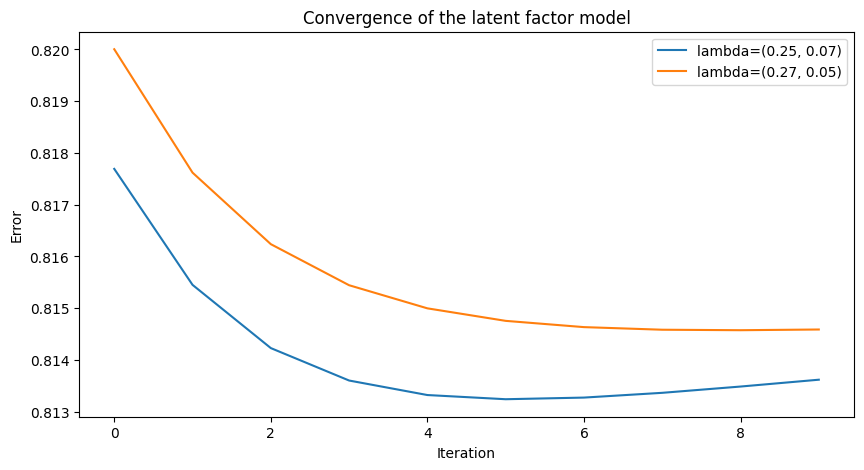

In [ ]:
plt.figure(figsize=(10, 5))
for lambda_ in [(0.25,0.07),(0.27,0.05)]:
    P, Q,E,L = derive_latent_factor(R_train,R_test, 1, 20, 0.01, lambda_[0],lambda_[1])
    plt.plot(L[10:], label=f"lambda={lambda_}")
plt.title('Convergence of the latent factor model')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.show()

Training latent factors: 100%|██████████| 20/20 [00:58<00:00,  2.93s/iteration]


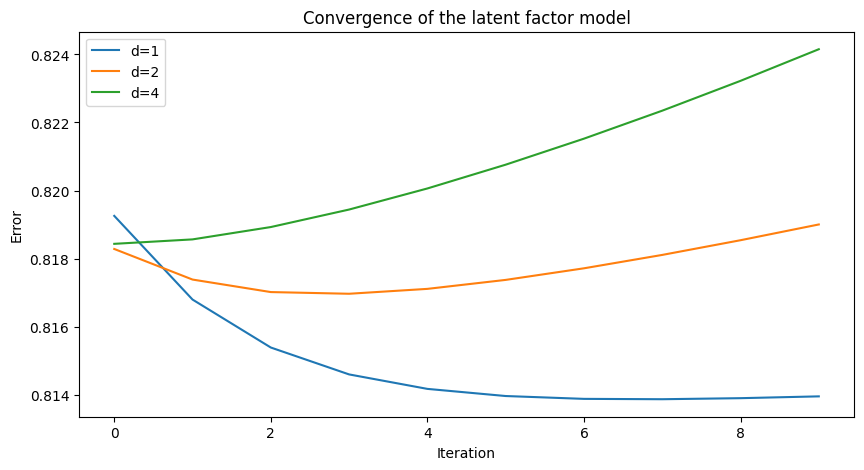

In [ ]:
plt.figure(figsize=(10, 5))
for d in [1,2,4]:
    P, Q,E,L = derive_latent_factor(R_train,R_test,d, 20, 0.01, 0.25,0.07)
    plt.plot(L[10:], label=f"d={d}")
plt.title('Convergence of the latent factor model')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.show()

Training latent factors: 100%|██████████| 20/20 [00:58<00:00,  2.92s/iteration]


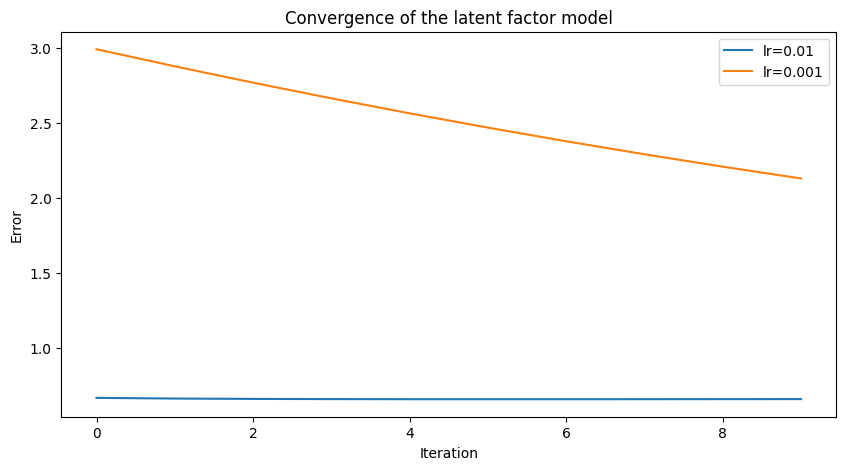

In [ ]:
plt.figure(figsize=(10, 5))
for lr in [0.01, 0.05]:
    P, Q,E,L = derive_latent_factor(R_train,R_test, 1, 20, lr, 0.2)
    plt.plot(L[10:], label=f"lr={lr}")
plt.title('Convergence of the latent factor model')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.show()

Training latent factors: 100%|██████████| 40/40 [02:00<00:00,  3.01s/iteration]


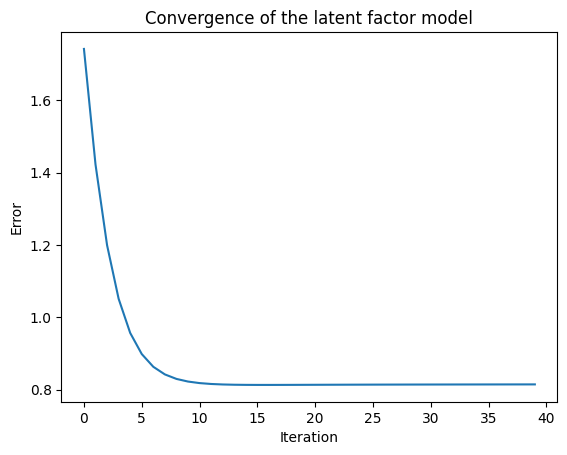

16


In [ ]:
P, Q,E,L = derive_latent_factor(R_train,R_test, 1, 40, 0.01, 0.25,0.07)
plt.plot(L)
plt.title('Convergence of the latent factor model')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.show()

print(np.argmin(L))

In [36]:
P, Q,E,L = derive_latent_factor(R_train,R_test, 1, 16, 0.01, 0.25,0.07)

Training latent factors: 100%|██████████| 16/16 [00:47<00:00,  2.97s/iteration]


In [50]:
Rhat = np.dot(P, Q.T)
test["rating_approx"] = np.nan
for _, row in tqdm(test.iterrows(), total=len(test), desc="Predicting ratings"):
    user_idx = user_map.get(row['user_id'])
    item_idx = item_map.get(row['book_id'])
    test.at[_, 'rating_approx'] = Rhat[user_idx, item_idx]

print("RMSE on test set:", np.sqrt(np.nanmean((test['rating'] - test['rating_approx'])**2)))


Predicting ratings: 100%|██████████| 3819/3819 [00:00<00:00, 19668.09it/s]

RMSE on test set: 0.8136788233017616


In [1]:
from itertools import product

def generate_hyperparameter_combinations(hyperparameters):

    keys = list(hyperparameters.keys())
    values = list(hyperparameters.values())
    
    # Générer les combinaisons
    combinations = product(*values)
    
    # Transformer les combinaisons en une liste de dictionnaires
    result = [dict(zip(keys, combination)) for combination in combinations]
    return result

def hyperparam_tuning (y_test,hyperparameters):
    best_rmse= 1
    best_hyperparameters = {}
    combinations = generate_hyperparameter_combinations(hyperparameters)
    for hyperparameter in tqdm(combinations):
        P,Q,E,L = derive_latent_factor(R_train,R_test, hyperparameter['d'],hyperparameter['n_epochs'], hyperparameter['lr'], hyperparameter['lambda_P'],hyperparameter['lambda_Q'])
        rmse = np.min(L)
        if rmse < best_rmse:
            best_rmse = rmse
            min_idx = np.argmin(L)
            best_hyperparameters = hyperparameter
    print('Best hyperparameters:', best_hyperparameters, 'Best RMSE:', best_rmse, 'at epoch', min_idx)




In [9]:
hyperparameters = {'d':[1,2,5,10],'n_epochs':[20],'lr':[0.001,0.01,0.05],'lambda_P':[0.25,0.27],'lambda_Q':[0.05,0.07]}

In [51]:
Rhat = np.dot(P, Q.T)

In [52]:
# P,Q,E,L = derive_latent_factor(R, 100, 50, 0.01, 0.01)
Rhat = np.dot(P, Q.T)
train["rating_approx"] = np.nan
for _, row in tqdm(train.iterrows(), total=len(train), desc="Predicting ratings"):
    user_idx = user_map.get(row['user_id'])
    item_idx = item_map.get(row['book_id'])
    train.at[_, 'rating_approx'] = Rhat[user_idx, item_idx]

print("RMSE on training set:", np.sqrt(np.nanmean((train['rating'] - train['rating_approx'])**2)))
train.head()

Predicting ratings: 100%|██████████| 96704/96704 [00:04<00:00, 22640.12it/s]

RMSE on training set: 0.758805817923752


,book_id,user_id,rating,rating_approx
0,7260,20145,3.5,2.048941
1,243238,85182,4.0,3.697559
4,243293,81002,5.0,4.894399
6,243351,91860,5.0,5.328308
7,245558,94079,4.0,1.771999


In [53]:
test = pd.read_csv('/users/eleves-b/2021/madeleine.hueber/DIS_project2/data/test.csv')
test["rating"] = np.nan
for _, row in tqdm(test.iterrows(), total=len(test), desc="Predicting ratings"):
    user_idx = user_map.get(row['user_id'])
    item_idx = item_map.get(row['book_id'])
    test.at[_, 'rating'] = Rhat[user_idx, item_idx]

test.head()

Predicting ratings: 100%|██████████| 29367/29367 [00:01<00:00, 22682.83it/s]


,id,book_id,user_id,rating
0,0,3786,40484,1.716812
1,1,1985,47039,1.832922
2,2,2290,60111,0.994700
3,3,118657,64447,1.449923
4,4,1560,2953,2.072810


In [54]:
sample_submission = pd.read_csv('/users/eleves-b/2021/madeleine.hueber/DIS_project2/data/sample_submission_baseline.csv')
sample_submission["rating"] = test["rating"]
sample_submission.to_csv('/users/eleves-b/2021/madeleine.hueber/DIS_project2/data/submission.csv', index=False)